Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# If there are GPUs, choose the first one for computing. Otherwise use CPU.
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)  
# If 'cuda:0' is printed, it means GPU is available.

Files already downloaded and verified
Files already downloaded and verified
mps


In [2]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1   = nn.Linear(16*5*5, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.avg_pool2d(out, 2)
        out = F.relu(self.conv2(out))
        out = F.avg_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

net = LeNet()     # Create the network instance.
net.to(device)  # Move the network parameters to the specified device.

LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [3]:
# We use cross-entropy as loss function.
loss_func = nn.CrossEntropyLoss()  
# We use stochastic gradient descent (SGD) as optimizer.
opt = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) 

In [4]:
avg_losses = []   # Avg. losses.
epochs = 32       # Total epochs.
print_freq = 100  # Print frequency.

for epoch in range(epochs):  # Loop over the dataset multiple times.
    running_loss = 0.0       # Initialize running loss.
    for i, data in enumerate(trainloader, 0):
        # Get the inputs.
        inputs, labels = data
        
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients.
        opt.zero_grad()

        # Forward step.
        outputs = net(inputs)
        loss = loss_func(outputs, labels)
        
        # Backward step.
        loss.backward()
        
        # Optimization step (update the parameters).
        opt.step()

        # Print statistics.
        running_loss += loss.item()
        if i % print_freq == print_freq - 1: # Print every several mini-batches.
            avg_loss = running_loss / print_freq
            print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f}'.format(
                epoch, i, avg_loss))
            avg_losses.append(avg_loss)
            running_loss = 0.0

print('Finished Training.')

[epoch: 0, i:    99] avg mini-batch loss: 2.305
[epoch: 0, i:   199] avg mini-batch loss: 2.305
[epoch: 0, i:   299] avg mini-batch loss: 2.304
[epoch: 0, i:   399] avg mini-batch loss: 2.302
[epoch: 0, i:   499] avg mini-batch loss: 2.299
[epoch: 0, i:   599] avg mini-batch loss: 2.305
[epoch: 0, i:   699] avg mini-batch loss: 2.304
[epoch: 0, i:   799] avg mini-batch loss: 2.297
[epoch: 0, i:   899] avg mini-batch loss: 2.307
[epoch: 0, i:   999] avg mini-batch loss: 2.298
[epoch: 0, i:  1099] avg mini-batch loss: 2.297
[epoch: 0, i:  1199] avg mini-batch loss: 2.295
[epoch: 0, i:  1299] avg mini-batch loss: 2.301
[epoch: 0, i:  1399] avg mini-batch loss: 2.293
[epoch: 0, i:  1499] avg mini-batch loss: 2.287
[epoch: 0, i:  1599] avg mini-batch loss: 2.272
[epoch: 0, i:  1699] avg mini-batch loss: 2.259
[epoch: 0, i:  1799] avg mini-batch loss: 2.217
[epoch: 0, i:  1899] avg mini-batch loss: 2.230
[epoch: 0, i:  1999] avg mini-batch loss: 2.192
[epoch: 0, i:  2099] avg mini-batch loss

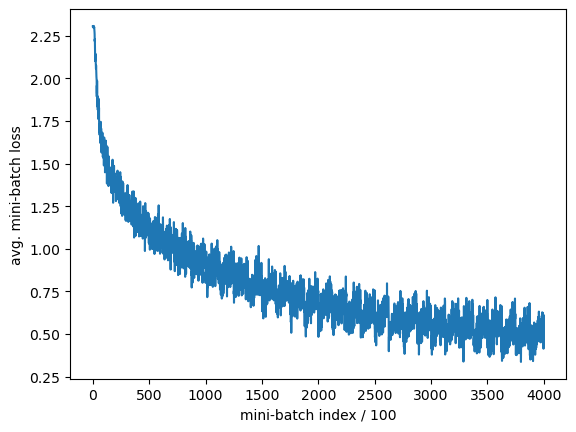

In [5]:
plt.plot(avg_losses)
plt.xlabel('mini-batch index / {}'.format(print_freq))
plt.ylabel('avg. mini-batch loss')
plt.show()

In [6]:
# Get test accuracy.
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 59 %


In [7]:
# Get train accuracy.
correct = 0
total = 0
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 50000 train images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 50000 train images: 83 %
